Investigate a simple system where you only have 1 neurons connected to itself with a synapse.
This means there are only two state variables: V, s.

In [2]:
import matplotlib.pylab as plt
import numpy as np
import scipy.integrate as integrate
from scipy.optimize import fsolve
from sympy.core.symbol import symbols
from sympy.solvers.solveset import nonlinsolve
from sympy import lambdify
#%matplotlib notebook

C = 0.015
Gc = 0.1
Ec = -35.0
ar = 1.0/1.5
ad = 5.0/1.5
B = 0.125
# Chemical self synapse Gs = 1

def dv_dt(v, s, Iext):
  leak_current = Gc * (v - Ec)
  syn_current = s * v
  return (- leak_current - syn_current + Iext) / C

def ds_dt(v, s, Iext):
  vth = compute_vth(Iext)
  phi = np.reciprocal(1.0 + np.e ** (-B*(v - vth)))
  return ar * phi * (1 - s) - ad * s

# Analytical way of computing vth.
def compute_vth(Iext):
  s_eq = ar / (ar + 2 * ad)
  return (Gc * Ec + Iext) / (Gc + s_eq)

# The numerical way of computing vth
def compute_vth_with_fsolve(Iext):
  s_eq = ar / (ar + 2 * ad)
  def dv_dt_eq_0(v):
    return dv_dt(v, s_eq, Iext)
  return fsolve(dv_dt_eq_0, 0.1)

# Returns a function s = f(v) when dv/dt = 0
def solve_v_nullcline(Iext):
  v, s = symbols('v s')
  # This symbolically solves for s in terms of v when dv/dt = 0
  sol = nonlinsolve([dv_dt(v, s, Iext)], [s])
  # This converts the symbolic solution to a function
  return lambdify(v, next(iter(sol))[0])

# Returns a function s = f(v) when ds/dt = 0
def solve_s_nullcline(Iext):
  v, s = symbols('v s')
  # This symbolically solves for s in terms of v when ds/dt = 0
  sol = nonlinsolve([ds_dt(v, s, Iext)], [s])
  # This converts the symbolic solution to a function
  return lambdify(v, next(iter(sol))[0])

# Plot V(t) and phase portrait trajectory for given initial conditions (v, s) and the injected currents.
def plot_trajectory(v, s, Iext):
  def dyn(t, state_vars):
    v = state_vars[0]
    s = state_vars[1]
    return [dv_dt(v, s, Iext), ds_dt(v, s, Iext)]

  # Plot V(t)
  dt = 0.1
  t_max = 2
  t_span = [0, t_max]
  t_eval = np.arange(0, t_max, dt)
  sol = integrate.solve_ivp(dyn, t_span, [v, s], method = 'RK45', t_eval = t_eval)
  
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
  ax.plot(sol.t, sol.y[0], label = "V")
  ax.plot(sol.t, sol.y[1], label = "S")
  ax.legend()
  
  # Plot phase portrait
  num_dots = 10
  min_max_scale = 70
  vmin = -1 * min_max_scale
  vmax = min_max_scale
  vspacing = min_max_scale / num_dots * 2
  vlist = np.arange(vmin, vmax+vspacing, vspacing)
  smin = 0.0
  smax = 1.0
  sspacing = 1.0 / num_dots
  slist = np.arange(0.0, smax+sspacing, sspacing)
  vmat, smat = np.meshgrid(vlist, slist)

  dv_dt_mat = np.zeros(vmat.shape)
  ds_dt_mat = np.zeros(smat.shape)

  for i in range(vmat.shape[0]):
    for j in range(vmat.shape[1]):
      v = vmat[i][j]
      s = smat[i][j]
      dv_dt_mat[i][j] = dv_dt(v, s, Iext)
      # Rescaling so we can see the s arrows.
      ds_dt_mat[i][j] = ds_dt(v, s, Iext) * 1000
  
  v_nullcline = solve_v_nullcline(Iext)
  s_nullcline = solve_s_nullcline(Iext)
  
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
  ax.quiver(vmat, smat, dv_dt_mat, ds_dt_mat, color = 'blue')
  nullcline_v_list = np.arange(vmin, vmax + 1.3, 1.3)
  neg_nullcline_v_list = nullcline_v_list[nullcline_v_list < 0]
  pos_nullcline_v_list = nullcline_v_list[nullcline_v_list > 0]
  # The v nullcline is of the form s(v) = 1/v * c1 + c2, so we need to plot separately.
  # For positive s, however, we actually only will ever see the pos_v_nullcline
  # ax.plot(neg_nullcline_v_list, v_nullcline(neg_nullcline_v_list), label = "neg_v_nullcline")
  ax.plot(pos_nullcline_v_list, v_nullcline(pos_nullcline_v_list), label = "v_nullcline")
  # The s nullcline looks like a sigmoid.
  ax.plot(nullcline_v_list, s_nullcline(nullcline_v_list), label = "s_nullcline")
  ax.set_xlabel("V")
  ax.set_ylabel("S")
  ax.set_ylim(0,1.0)
  ax.legend()
  
  # Plot trajectory on phase portrait
  p = ax.scatter(sol.y[0], sol.y[1], c = sol.t, cmap = 'viridis')
  plt.colorbar(p)

plot_trajectory(v = 50, s = 0.5, Iext = 10)

Okay, not too terribly exciting. We can only have 1 equilibrium seeing the shapes of the nullclines (sigmoid and positive 1/x). Let's plot a bifurcation diagram just to make sure there really is nothing interesting.

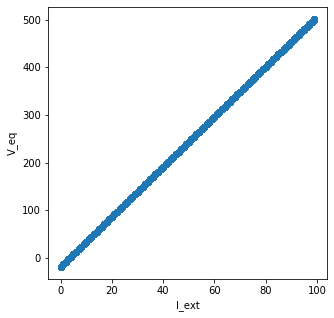

In [3]:
Iexts = []
Veqs = []

def dyn(t, state_vars):
  v = state_vars[0]
  s = state_vars[1]
  return [dv_dt(v, s, Iext), ds_dt(v, s, Iext)]

for Iext in np.arange(0, 100, 1):
  # Initial conditions
  v = 0
  s = 0.1
  num_samples = 10
  dt = 0.1
  t_max = 10
  t_span = [0, t_max]
  # Collect just the last num_samples of the iteration to check if equilibrium or not.
  t_eval = np.arange(t_max - num_samples * dt, t_max, dt)
  sol = integrate.solve_ivp(dyn, t_span, [v, s], method = 'RK45', t_eval = t_eval)
  # Collect (Iext, v_sample) tuples from this run.
  Iexts.extend([Iext] * num_samples)
  Veqs.extend(sol.y[0])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.scatter(Iexts, Veqs)
ax.set_ylabel("V_eq")
_ = ax.set_xlabel("I_ext")

Urk. Nothing interesting to see here. Just one stable equilibrium all the way.
Alternatively we can do proper bifurcation theory and see how the jacobians change. But... from this graph, pretty sure no interesting bifurcation will happen.